# Probability and Distinctive Words

This notebook has three parts. 

1. We start by reviewing the Pearson correlation coefficient and the concept of a *p* value.

2. Then we ask how much we can learn about a film from its title. We construct a *term-document* matrix for the films in *The Pudding* dataset, practice different ways of finding distinctive words, and review probability notation.

3. Finally (if we get to it) we'll consider different ways of predicting a film's gender balance from its title, mainly in order to expose a problem with straightforward linear regression.

As usual, we start by importing some familiar useful modules.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import math
pd.set_option('display.max_rows', 100)

Last time we did a lot of merging datasets in order to construct a single table with all the information we need in one place, including the fraction of words in each film spoken by women. I've written that dataset to disk and saved it in the repo, using the "to_csv" command:

    titledata.to_csv('titledata_movies.tsv', sep = '\t', index = False)


Now we can load it using the ```read_csv``` command. Notice that we have to specify that this is a tab-separated file, because that's how I saved it.

In [2]:
title = pd.read_csv('titledata_movies.tsv', sep = '\t', encoding = 'utf-8')

The ```.head()``` function is a good way to remind ourselves of the column titles. Let's also rename 'year' to 'releaseyr'; later on we're going to have word frequencies for the word 'year' and it could get confusing.

In [3]:
title = title.rename(columns = {'year': 'releaseyr'})
title.head()

,title,words_men,words_women,frac_women,script_id,imdb_id,releaseyr,gross
0,(500) Days of Summer,12762.0,5738.0,0.310162,1534,tt1022603,2009,37.0
1,10 Things I Hate About You,10688.0,8992.0,0.456911,1512,tt0147800,1999,65.0
2,12 Years a Slave,16176.0,3452.0,0.175871,1517,tt2024544,2013,60.0
3,12 and Holding,10644.0,5324.0,0.333417,1514,tt0417385,2005,NaN
4,127 Hours,4336.0,809.0,0.157240,1520,tt1542344,2010,20.0


I'm also going to replace ```NaN``` values in the gross column with a mean value. Don't necessarily do this at home; I'm doing it to simplify a step later, because classroom exercises need to be streamlined -- but it's not always a safe assumption that missing data is roughly the mean.

In [4]:
title = title.fillna(value = np.nanmean(title['gross']))
title.head()

,title,words_men,words_women,frac_women,script_id,imdb_id,releaseyr,gross
0,(500) Days of Summer,12762.0,5738.0,0.310162,1534,tt1022603,2009,37.000000
1,10 Things I Hate About You,10688.0,8992.0,0.456911,1512,tt0147800,1999,65.000000
2,12 Years a Slave,16176.0,3452.0,0.175871,1517,tt2024544,2013,60.000000
3,12 and Holding,10644.0,5324.0,0.333417,1514,tt0417385,2005,103.940433
4,127 Hours,4336.0,809.0,0.157240,1520,tt1542344,2010,20.000000


## 1. Reviewing the Pearson correlation coefficient

You'll recall that there was a weak positive correlation between ```releaseyr``` and the proportion of dialogue spoken by women.

The numpy function "polyfit" allows us to quickly represent that as a trend line, and Pearson correlation allows us to measure--not the slope of the trend--but the amount of variance in the variables it explains.

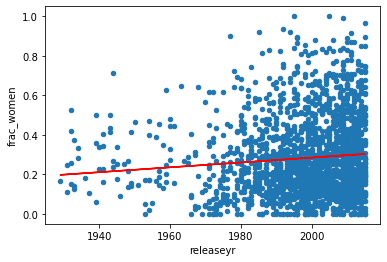

In [6]:
title.plot(kind = 'scatter', x = 'releaseyr', y = 'frac_women')

z = np.polyfit(title.releaseyr, title.frac_women, 1)
p = np.poly1d(z)
plt.plot(title.releaseyr,p(title.releaseyr),"r-")

plt.show()

In [7]:
pearsonr(title['releaseyr'], title['frac_women'])

(0.09236705889251742, 3.5180809095464426e-05)

The *r* value, measuring the strength of the correlation, is .092.

Let's get a better feeling for what that really means.

We'll play around with an artificial data-generation process.

The following cell will generate 100 data points randomly, and then add a relationship between them that you can adjust by changing the value of *relationship_strength* from a large negative number to a large positive one.

R for this sample is  -0.32875
and the p value is 0.0008393038474163289


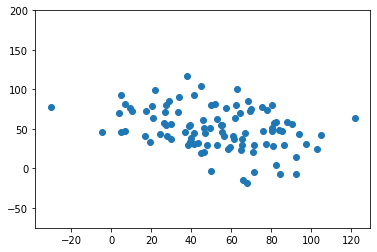

In [8]:
relationship_strength = -0.4

x = np.random.normal(loc = 50, scale = 25, size = 100)
y = np.random.normal(loc = 50, scale = 25, size = 100) + (x - 50) * relationship_strength

plt.scatter(x, y)
plt.ylim(-75, 200)
r, p = pearsonr(x, y)
print('R for this sample is ', round(r, 5))
print('and the p value is', p)

As you change the number, observe what happens to the cloud of points and the *r* statistic.

The null hypothesis for correlation is that there is actually no relationship between x and y in the population from which the sample was drawn; according to the null hypothesis, the true population correlation coefficient is 0. 

The p value indicates how often we would see a correlation of the observed strength in a random sample from such a population.

**DISCUSSION: How could we use bootstrap resampling to test this?**

## 2. Titles and gender

We've measured the obvious quantitative relationships in this dataset. But there might be more to learn. For instance, if we want to understand why movies display such a strong male bias, we might be curious whether the problem is limited to a few types of movies, or whether it's widespread.

We don't have a "genre" column in this dataset (and genre categorization might be controversial anyway). But we can begin to learn *something* about the relationship between a movie's content (or marketing) and its gender bias by investigating titles.

One crude way to do this is just to sort the data.

In [9]:
sorted_titles = title.sort_values(by = 'frac_women')
sorted_titles.head()

,title,words_men,words_women,frac_women,script_id,imdb_id,releaseyr,gross
1999,There Will Be Blood,8052.0,0.0,0.0,6000,tt0469494,2007,50.000000
1968,Kiss of the Spider Woman,7419.0,0.0,0.0,2711,tt0089424,1985,103.940433
1990,The Bunker,6248.0,0.0,0.0,3977,tt0252963,2001,103.940433
1975,Pat Garrett & Billy the Kid,3133.0,0.0,0.0,7210,tt0070518,1973,103.940433
1989,The Battle of Algiers,6862.0,0.0,0.0,1780,tt0058946,1966,6.000000


In [10]:
sorted_titles.tail()

,title,words_men,words_women,frac_women,script_id,imdb_id,releaseyr,gross
1558,The Hand That Rocks the Cradle,626.0,8823.0,0.933750,8480,tt0104389,1992,184.000000
902,Martyrs,109.0,3055.0,0.965550,8614,tt1663655,2015,103.940433
1101,Precious,114.0,17536.0,0.993541,3124,tt0929632,2009,55.000000
1494,The Descent,0.0,4076.0,1.000000,7695,tt0435625,2005,35.000000
1025,Now and Then,0.0,4186.0,1.000000,4723,tt0114011,1995,54.000000


But two thousand titles are a lot of titles to sort through this way. Another possibility is to look for title words that distinctively characterize films where there is relatively little, or relatively a lot, of dialogue spoken by women.

The first thing we need to do is just count the words. You'll recall in our first lab we did that a complicated way, and then introduced a simple way to do it with a Python class called CountVectorizer.

A class, in Python, will usually have a name that starts with a capital letter. It's not just a generic function that can be applied to anything; a class is a *category* of thing. To use it, you need to create an example of that category. We talked about this as creating a "little demon" who will then do what you want.

So we first import ```CountVectorizer```, and then create an example. In the process of creating it, we'll tell it to only count the top 100 words in the titles.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 100, stop_words = ['the', 'of', 'and'])

An odd feature of the CountVectorizer is that it initially returns its wordcounts as a "sparse" matrix to save memory. We need to convert that into a regular numpy array before doing much with it.

In [12]:
sparse_wordcounts = vectorizer.fit_transform(title['title'])
wordcounts = sparse_wordcounts.toarray()

We can get the list of the top 100 words the CountVectorizer used by asking it to ```.get_feature_names()```

In [13]:
features = vectorizer.get_feature_names()

print(features)

['13th', 'all', 'america', 'american', 'an', 'at', 'back', 'bad', 'big', 'black', 'blood', 'blue', 'boy', 'boys', 'city', 'dark', 'day', 'days', 'dead', 'dragon', 'end', 'episode', 'evil', 'eyes', 'fear', 'final', 'fire', 'first', 'for', 'four', 'friday', 'from', 'get', 'ghost', 'girl', 'go', 'good', 'green', 'halloween', 'hard', 'harry', 'her', 'house', 'ii', 'iii', 'in', 'is', 'it', 'king', 'last', 'legend', 'life', 'little', 'lost', 'love', 'man', 'me', 'men', 'movie', 'mr', 'my', 'new', 'night', 'nightmare', 'no', 'on', 'one', 'out', 'park', 'part', 'people', 'planet', 'point', 'potter', 'red', 'return', 'rise', 'rock', 'rocky', 'seven', 'star', 'street', 'things', 'time', 'to', 'trek', 'two', 'up', 'war', 'wars', 'wedding', 'white', 'who', 'wild', 'with', 'woman', 'world', 'year', 'you', 'your']


Now we can convert ```wordcounts``` into a Pandas data frame that will be easy to manipulate.

In [20]:
wordcounts = pd.DataFrame(wordcounts, columns = features)

This is a *document-term matrix*, a data object that will be quite useful throughout much of the rest of the course. Here's what it looks like:

In [21]:
wordcounts

,13th,all,america,american,an,at,back,bad,big,black,...,wedding,white,who,wild,with,woman,world,year,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We can also combine it with our metadata about movies, to produce a master ```data``` data frame.

In [16]:
data = pd.concat([wordcounts, title], axis = 1)
data.head()

,13th,all,america,american,an,at,back,bad,big,black,...,you,your,title,words_men,words_women,frac_women,script_id,imdb_id,releaseyr,gross
0,0,0,0,0,0,0,0,0,0,0,...,0,0,(500) Days of Summer,12762.0,5738.0,0.310162,1534,tt1022603,2009,37.000000
1,0,0,0,0,0,0,0,0,0,0,...,1,0,10 Things I Hate About You,10688.0,8992.0,0.456911,1512,tt0147800,1999,65.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,12 Years a Slave,16176.0,3452.0,0.175871,1517,tt2024544,2013,60.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,12 and Holding,10644.0,5324.0,0.333417,1514,tt0417385,2005,103.940433
4,0,0,0,0,0,0,0,0,0,0,...,0,0,127 Hours,4336.0,809.0,0.157240,1520,tt1542344,2010,20.000000


Now we can reproduce the analysis Ben Schmidt carried out on two different categories of books, and find out which of these words are significantly overrepresented in movies with more, or less, dialogue by women.

We don't necessarily have to treat this as a binary question. We could use the actual value of ```frac_women,``` and in a moment we'll see how. But for the moment, to explore the uses of probability, let's divide the movies into two groups. Those with less than the median amount of dialogue by women, and those with the median or above.

Note that the median is pretty low!! So let's call the group with more women "less biased" rather than actually "feminine."

In [17]:
median_frac = np.median(title['frac_women'])
print(median_frac)

0.2432355697476658


#### GROUP EXERCISE 1:

Pandas review. 

1. Select all movies where data['frac_women'] is less than median_frac, and all the columns that count words. 

2. Select movies where data['frac_women'] is >= than median_frac, and all the columns that count words.

You can do this with ```.loc[]``` Note that we've put the list of words we're using in a variable ```words```, and you can you can select all the word columns by putting that variable in the columns position of ```.loc[]```.

When you've got these dataframes you can flatten them into a single series of word counts by saying ```df.sum(axis = 0)```.

In [144]:
# select malebiased, and calculate sums

In [18]:
# select lessbiased, and calculate sums

When you're done you should have a list like this:

In [24]:
malebiased[0:10]

13th        0
all         3
america     4
american    9
an          4
at          5
back        6
bad         4
big         5
black       7
dtype: int64

## 3. Finding distinctive words

To explore the relation between titles and gender, we want to create a visualization a bit like the one Ben Schmidt used to visualize distinctive words.

![Ben Schmidt's illustration of additive and multiplicative comparisons](schmidtillus.png)

Before we can do that, we may need some practice labeling scatterplots in Python.

Here's an example. We can create the dots simply with the plt.scatter() command.

But we have to label each point individually, using a for-loop. Notice how we use the zip() function to create aligned triplets of coordinates and labels. I'm also adding a little randomness to the vertical position of the label; later, this will help keep labels from overplotting each other.

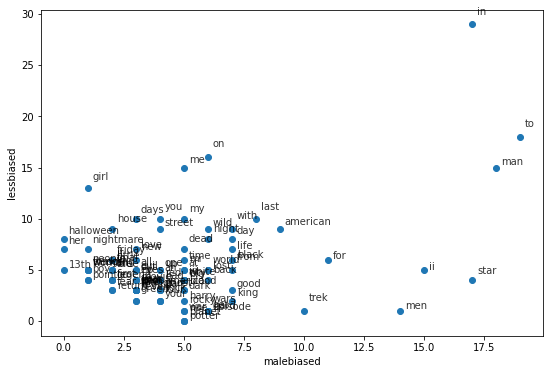

In [25]:
plt.figure(figsize = (9, 6))
plt.scatter(x = malebiased.values, y = lessbiased.values)

for x, y, label in zip(malebiased.values, lessbiased.values, malebiased.index):
    plt.text(x = x + .2, y = y + np.random.random(), s = label, fontdict = dict(color = 'black', alpha = 0.8))

plt.xlabel('malebiased')
plt.ylabel('lessbiased')
plt.show()

#### EXERCISE 2

Okay now, working in groups, produce a labeled visualization of words where the x axis is

    malebiased - lessbiased

and the y axis is

    malebiased / lessbiased

This will tell you which words are overrepresented in films with a lot of male dialogue.

Because it's hard to visualize the overrepresentation in both categories at once, you may want to produce two graphs, and flip the relationship in the second, so the y axis of the second one plots ```lessbiased / malebiased.``` If you like, you can use indexing to remove points with a negative x value.

If you get some errors related to infinite values, you might also consider adding one to both sides of the ratio, like so:

    (malebiased + 1) / (lessbiased + 1)

Think about why that solves the problem.

In [27]:
# visualize overrepresentation on the malebiased side

In [26]:
# visualize overrepresentation on the lessbiased side

## 4. Calculating overrepresentation using Dunning's log likelihood

These graphs are interesting, but they don't give us a single, ranked list of words that characterize one group of movies or the other.

To get that ranked list, we can use the method Schmidt recommended in his blog post: Dunning's log likelihood. This is an example of a procedure called a G-test that uses a probability table to compromise between "additive" and "divisive" measures.

We start by constructing a simple 2x2 table. Let's take the word "house."

In [28]:
observed = pd.DataFrame({'lessbiased': [lessbiased['house'], sum(lessbiased) - lessbiased['house']],
                          'malebiased': [malebiased['house'], sum(malebiased) - malebiased['house']]},
                        index = ['word', 'all_others'])
total_words = observed.to_numpy().sum()
print(total_words)
observed

1001


,lessbiased,malebiased
word,9,2
all_others,514,476


Then we convert this into a probability table in two steps. First, take the sums of rows and columns.

In [29]:
observed['word_totals'] = observed.sum(axis = 1)
observed

,lessbiased,malebiased,word_totals
word,9,2,11
all_others,514,476,990


In [ ]:
observed = observed.append(observed.sum(axis = 0).rename(index = 'group_totals'))
observed.iat[2,2] = 0
observed

Convert marginal values into marginal probabilities.

In [ ]:
observed['word_totals'] = observed['word_totals'] / sum(observed['word_totals'])
observed.loc['group_totals', : ] = observed.loc['group_totals', : ] / sum(observed.loc['group_totals', : ])
observed

In [ ]:
expected = np.outer(observed['word_totals'][0:2], observed.loc['group_totals', : ][0:2])
expected = pd.DataFrame(expected, index = ['word', 'all_others'], columns = ['lessbiased', 'malebiased'])
expected

**INDIVIDUAL EXERCISE**:

These are *joint probabilities*. The value in cell 0, 0 could be expressed as $P(house \cap lessbiased)$

How would we calculate a conditional probability? For instance what is $P(lessbiased \mid house)$? Notice the difference between expressing these relationships as probabilities and as "odds."

In the cell below briefly calculate $P(lessbiased \mid house)$.

In [391]:
# calculate the conditional probability that a word came from 
# the title of a less gender-biased movie, given that we know the word is "house"



In [ ]:
expected = expected * total_words
expected

In [ ]:
G = 0
for i in range(2):
    for j in range(2):
        O = observed.iat[i, j]
        E = expected.iat[i, j]
        G = G + O * math.log(O / E)
G = 2 * G
G

In [30]:
def get_dunnings(word, series1, series2):
    observed = pd.DataFrame({'series1': [series1[word], sum(series1) - series1[word]],
                          'series2': [series2[word], sum(series2) - series2[word]]},
                        index = ['word', 'all_others'])
    total_words = observed.to_numpy().sum()
    observed['word_totals'] = observed.sum(axis = 1)
    observed = observed.append(observed.sum(axis = 0).rename(index = 'group_totals'))
    observed.iat[2,2] = 0
    observed['word_totals'] = observed['word_totals'] / sum(observed['word_totals'])
    observed.loc['group_totals', : ] = observed.loc['group_totals', : ] / sum(observed.loc['group_totals', : ])
    expected = np.outer(observed['word_totals'][0:2], observed.loc['group_totals', : ][0:2])
    expected = pd.DataFrame(expected, index = ['word', 'all_others'], columns = ['lessbiased', 'malebiased'])
    expected = expected * total_words
    
    G = 0
    for i in range(2):
        for j in range(2):
            O = observed.iat[i, j] + .000001
            E = expected.iat[i, j] + .000001
            G = G + O * math.log(O / E)
    
    if observed.iat[0, 0] < observed.iat[0, 1]:
        G = -G    # we provide a signed version of the statistic to distinguish
                  # overrepresentation in the two categories
    
    return 2 * G

### GROUP EXERCISE 2

Write code that uses the function above to calculate Dunning's log-likelihood values for all the words in our list of ```features```. Then sort the list and look at the top 20 words and bottom 20 words.

Discuss the lists and point to select something that puzzles or interests you; your group will report that puzzling detail to the larger class discussion.

In [34]:
# code goes here

-9.470499341856467

In [37]:
dunnings.sort_values()[-20: ]

point         1.675397
boy           1.675397
it            1.762664
friday        1.762664
little        1.762664
you           2.174348
in            2.283826
people        2.577297
wedding       2.577297
things        2.577297
woman         2.577297
days          3.414758
on            3.944445
house         4.253457
me            4.457813
nightmare     4.570488
13th          6.514641
her           9.133441
halloween    10.445635
girl         11.283087
dtype: float64

## 5. Evaluating the strength of a relationship with multiple variables

If we want to know how well ```releaseyr``` can explain ```frac_women``` we can just take the Pearson correlation. We'll get a value for *r*, and if we square it we get $r^2$, the fraction of variance in y explained by x.

But what can we do if we want to know, for instance, how well *all* these title words can explain ```frac_women```? We can't take Pearson correlation with a hundred variables.

In principle we can use multiple linear regression to achieve this.

In [40]:
from sklearn import linear_model
from sklearn.metrics import r2_score

This technique works really well when we have a couple of predictive variables.

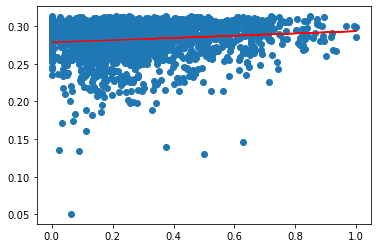

In [41]:
X = data.loc[ : , ['releaseyr', 'gross']]
y = data['frac_women']

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_pred = regr.predict(X)
plt.scatter(y, y_pred)

z = np.polyfit(y, y_pred, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r-")

plt.show()

In [42]:
print('Coefficient of determination: ', r2_score(y, y_pred))

Coefficient of determination:  0.014833951291363001


In [43]:
# Just proving that this is the same thing as squaring the Pearson correlation.

r, p = pearsonr(y, y_pred)
print('r2 = ', r **2)

r2 =  0.014833951291363013


### overfitting 

But notice what happens when we try this with title words and on the first 50 films.

In [ ]:
X = data.iloc[ 0: 50 , 0: 100]
y = data.iloc[0: 50, data.columns.tolist().index('frac_women')]

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_pred = regr.predict(X)
plt.scatter(y, y_pred)

z = np.polyfit(y, y_pred, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r-")

print('Coefficient of determination: ', r2_score(y, y_pred))

Wow — title words are really powerful! We can explain about half the variance in gender equality just by looking at the top hundred words in film titles.

Something's not right here.

**DISCUSSION:**

What's wrong here? Our linear regression was technically correct, as far as the code went. But our results are suspiciously good. How are we fooling ourselves?

And how could we test our model to prove that it's fooling us?

In [45]:
# code to prove we're being fooled will go here

## 6. How not to get fooled

We probably won't get to this material today, and it's not needed for the homework. However it's a hint about where we're headed next time.

In [355]:
data = data.sample(frac = 1)

train = data.iloc[0:1600]
test = data.iloc[1600:]

In [378]:
train_y = train['frac_women'] 
train_X = train.iloc[ : , 0: 100]

In [387]:
ridge = linear_model.Ridge(alpha = 10)
ridge.fit(train_X, train_y)

test_y = test['frac_women']
test_X = test.iloc[ : , 0: 100]

y_pred = ridge.predict(test_X)

print('Coefficient of determination: ', r2_score(test_y, y_pred))

Coefficient of determination:  0.016404113465274706


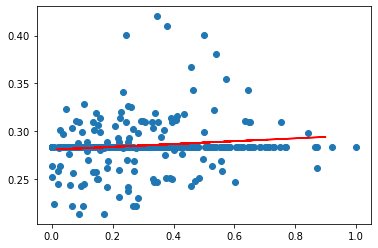

In [388]:
plt.scatter(test_y, y_pred)
z = np.polyfit(test_y, y_pred, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r-")